# Classfication Network Architecture V3

From V2 Notebook:
> Model 1: ResNet50 -> GAP -> DO -> Dense | 50 Epochs | Train Acc: 0.6768, Test Acc: 0.6756
> Model 2: Aug(flip,rot) -> ResNet50 -> GAP -> DO -> Dense | 50 Epochs | Train Acc: 0.6811, Test Acc: 0.6755



@date: 13-Aug-2020 | @author: katnoria

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model

In [12]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [13]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1


In [14]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [20]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True
)

In [21]:
len(ds_train), len(ds_test), metadata.features['label'].num_classes

(50000, 10000, 10)

In [22]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
metadata.features

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [23]:
NUM_CLASSES = metadata.features["label"].num_classes

num_train_examples = len(ds_train)
num_test_examples = len(ds_test)
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: 50000
Test dataset size: 10000


# Use Pretrained Models

Instead of training the full model, it is generally a good practice to use a pretrained network as a base model and add your layers on top. 
This allows us to reduce the training times and leverage on what base model has learned.

In [24]:
IMG_SIZE = 32
BATCH_SIZE = 64

Do not use the preprocessing we were using earlier, because we now use a pre-trained network as our feature extractor.

In [25]:
train_ds = ds_train \
    .cache() \
    .shuffle(num_train_examples).batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [26]:
example = train_ds.take(1)

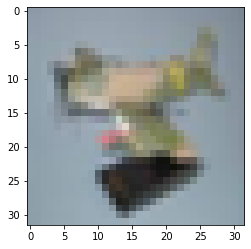

In [27]:
for images, labels in example:
    plt.imshow(images[0])

### Evaluation Pipeline

In [28]:
test_ds = ds_test \
    .cache() \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [29]:
def plot_history(history):
    plt.style.use('seaborn')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))    

    ax1.plot(acc, label="Training Accuracy")
    ax1.plot(val_acc, label="Validation Accuracy")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')    
    ax1.legend(loc='lower right')
    ax1.set_title("Training and Validation Accuracy")
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.plot(loss, label="Training Loss")
    ax2.plot(val_loss, label="Validation Loss")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')    
    ax2.legend(loc='upper right')
    ax2.set_title("Training and Validation Loss")
    
    plt.show()

In [30]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

# Data Augmentation

In [31]:
transforms = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
def get_pretrained_model(base_model, transforms=None):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if transforms is not None:
        x = transforms(inputs)
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
#     x = Flatten()(x)
#     x = Dense(128, activation='relu')(x)    
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [33]:
resnet_model_v2 = get_pretrained_model(base_model, transforms)
resnet_model_v2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)               

In [35]:
lr = 1e-4

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

resnet_model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [43]:
# Let's see the eval accuracy before we train the model
resnet_model_v2.evaluate(test_ds)

  1/156 [..............................] - ETA: 0s - loss: 6.6830 - accuracy: 0.0625WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0036s vs `on_test_batch_end` time: 0.0056s). Check your callbacks.


156/156 [==============================] - 1s 9ms/step - loss: 6.3933 - accuracy: 0.1025


[6.393298625946045, 0.10246394574642181]

In [36]:
# We are going to train for 50 epochs
history = resnet_model_v2.fit(
    train_ds, epochs=50, validation_data=test_ds, 
    verbose=2, callbacks=[reduce_lr]
)

Epoch 1/50
781/781 - 10s - loss: 3.2379 - accuracy: 0.3511 - val_loss: 1.6801 - val_accuracy: 0.5353
Epoch 2/50
781/781 - 9s - loss: 2.0505 - accuracy: 0.4934 - val_loss: 1.4079 - val_accuracy: 0.5850
Epoch 3/50
781/781 - 9s - loss: 1.7174 - accuracy: 0.5360 - val_loss: 1.2676 - val_accuracy: 0.6108
Epoch 4/50
781/781 - 9s - loss: 1.4946 - accuracy: 0.5681 - val_loss: 1.1707 - val_accuracy: 0.6290
Epoch 5/50
781/781 - 9s - loss: 1.3497 - accuracy: 0.5892 - val_loss: 1.1087 - val_accuracy: 0.6429
Epoch 6/50
781/781 - 9s - loss: 1.2534 - accuracy: 0.6053 - val_loss: 1.0701 - val_accuracy: 0.6464
Epoch 7/50
781/781 - 9s - loss: 1.1732 - accuracy: 0.6160 - val_loss: 1.0431 - val_accuracy: 0.6512
Epoch 8/50
781/781 - 9s - loss: 1.1141 - accuracy: 0.6288 - val_loss: 1.0197 - val_accuracy: 0.6552
Epoch 9/50
781/781 - 9s - loss: 1.0682 - accuracy: 0.6372 - val_loss: 0.9965 - val_accuracy: 0.6626
Epoch 10/50
781/781 - 9s - loss: 1.0337 - accuracy: 0.6481 - val_loss: 0.9881 - val_accuracy: 0.663

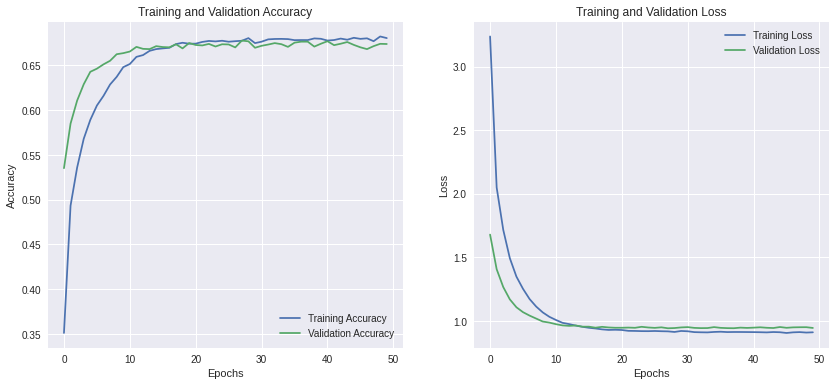

In [37]:
plot_history(history)

# Increase the network depth

If we notice the training accuracy, we see that we not not overfitting which probably means our network capacity is not enough. Let's now try to increase linear layers.

In [ ]:
def get_pretrained_model_v4(base_model, transforms=None):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if transforms is not None:
        x = transforms(inputs)
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
#     x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)        
    x = Dropout(0.7)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [68]:
resnet_model_v4 = get_pretrained_model_v4(base_model, transforms)
resnet_model_v4.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_6  [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_6 (Tenso [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)             

In [69]:
lr = 1e-3

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

resnet_model_v4.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [70]:
# We are going to train for 50 epochs
history = resnet_model_v4.fit(
    train_ds, epochs=50, validation_data=test_ds, 
    verbose=2, callbacks=[reduce_lr]
)

Epoch 1/50
781/781 - 10s - loss: 1.4959 - accuracy: 0.4979 - val_loss: 1.1074 - val_accuracy: 0.6092
Epoch 2/50
781/781 - 9s - loss: 1.2100 - accuracy: 0.5782 - val_loss: 1.0447 - val_accuracy: 0.6378
Epoch 3/50
781/781 - 9s - loss: 1.1276 - accuracy: 0.6067 - val_loss: 0.9995 - val_accuracy: 0.6501
Epoch 4/50
781/781 - 9s - loss: 1.0752 - accuracy: 0.6223 - val_loss: 0.9910 - val_accuracy: 0.6556
Epoch 5/50
781/781 - 9s - loss: 1.0253 - accuracy: 0.6410 - val_loss: 0.9754 - val_accuracy: 0.6642
Epoch 6/50
781/781 - 9s - loss: 0.9997 - accuracy: 0.6492 - val_loss: 0.9872 - val_accuracy: 0.6576
Epoch 7/50
781/781 - 9s - loss: 0.9655 - accuracy: 0.6586 - val_loss: 0.9607 - val_accuracy: 0.6680
Epoch 8/50
781/781 - 9s - loss: 0.9460 - accuracy: 0.6666 - val_loss: 0.9701 - val_accuracy: 0.6664
Epoch 9/50
781/781 - 9s - loss: 0.9180 - accuracy: 0.6759 - val_loss: 0.9729 - val_accuracy: 0.6629
Epoch 10/50
781/781 - 9s - loss: 0.8941 - accuracy: 0.6816 - val_loss: 0.9756 - val_accuracy: 0.667

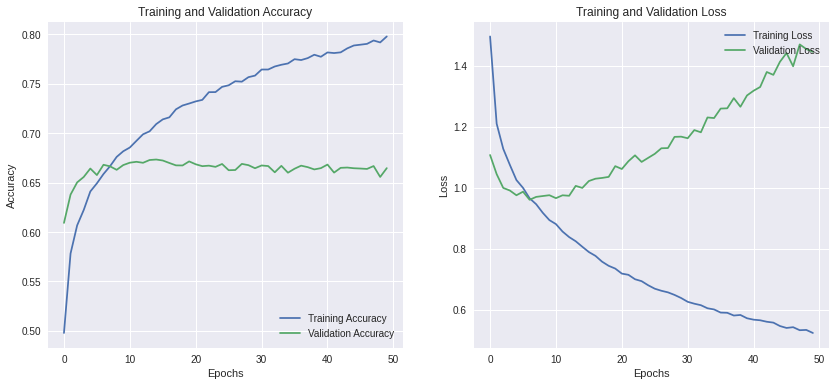

In [71]:
plot_history(history)

# Add Conv Layer
See: https://github.com/alexisbcook/keras_transfer_cifar10/blob/master/Keras_Transfer_CIFAR10.ipynb

In [94]:
# base_model.summary()

In [88]:
def get_pretrained_model_v5(base_model, transforms=None):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if transforms is not None:
        x = transforms(inputs)
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = Conv2D(256, 2, padding='same', input_shape=(1,1,2048))(x)
    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [89]:
resnet_model_v5 = get_pretrained_model_v5(base_model, transforms)
resnet_model_v5.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_14 [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_14 (Tens [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 256)         2097408   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 1, 256)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)             

In [92]:
lr = 1e-3

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

resnet_model_v5.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [93]:
# We are going to train for 50 epochs
history = resnet_model_v5.fit(
    train_ds, epochs=50, validation_data=test_ds, 
    verbose=2, callbacks=[reduce_lr]
)

Epoch 1/50
781/781 - 11s - loss: 2.1758 - accuracy: 0.5616 - val_loss: 1.0599 - val_accuracy: 0.6452
Epoch 2/50
781/781 - 10s - loss: 1.0327 - accuracy: 0.6446 - val_loss: 1.0219 - val_accuracy: 0.6468
Epoch 3/50
781/781 - 10s - loss: 0.9997 - accuracy: 0.6546 - val_loss: 1.0367 - val_accuracy: 0.6489
Epoch 4/50
781/781 - 10s - loss: 1.0063 - accuracy: 0.6554 - val_loss: 1.0337 - val_accuracy: 0.6522
Epoch 5/50
781/781 - 10s - loss: 1.0036 - accuracy: 0.6564 - val_loss: 1.0300 - val_accuracy: 0.6505
Epoch 6/50
781/781 - 10s - loss: 1.0103 - accuracy: 0.6562 - val_loss: 1.1319 - val_accuracy: 0.6329
Epoch 7/50
781/781 - 10s - loss: 1.0161 - accuracy: 0.6555 - val_loss: 1.0756 - val_accuracy: 0.6404
Epoch 8/50
781/781 - 10s - loss: 1.0068 - accuracy: 0.6607 - val_loss: 1.1035 - val_accuracy: 0.6400
Epoch 9/50
781/781 - 10s - loss: 1.0107 - accuracy: 0.6621 - val_loss: 1.1516 - val_accuracy: 0.6221
Epoch 10/50
781/781 - 10s - loss: 1.0009 - accuracy: 0.6658 - val_loss: 1.1223 - val_accura

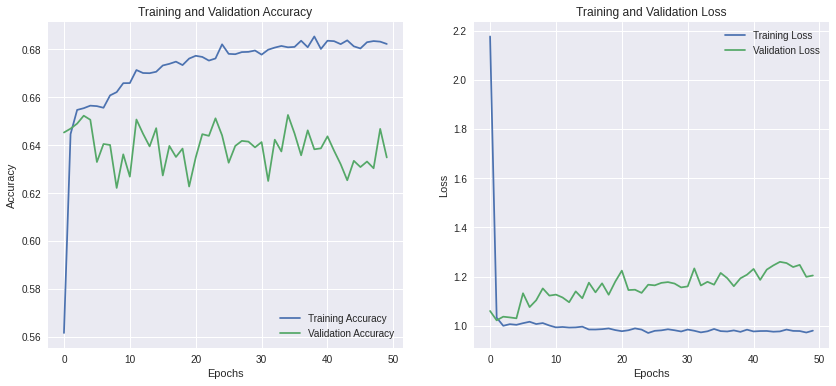

In [95]:
plot_history(history)